# Connectivity across groups

This notebook contains the code for the descriptive analysis of the connectivity across experimental groups: AVGP and NVGP.


In [2]:
%reload_ext autoreload
%autoreload 2

import pandas as pd
import xarray as xr
import scipy.stats as stats
import numpy as np
from src.acnets.pipeline import ConnectivityPipeline
from tqdm.autonotebook import tqdm
from IPython.display import clear_output

from src.acnets.pipeline import Parcellation

import seaborn as sns
import matplotlib.pyplot as plt

import pingouin as pg

sns.set('paper', 'white')

/tmp/ipykernel_16258/3823178135.py:9: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [3]:
pipe = ConnectivityPipeline(atlas='dosenbach2010',
                            kind='partial correlation',
                            timeseries_aggregation='network')
pipe.fit_transform(None)
data = pipe.dataset_

def shorten_network_name(name):
    return {
        'cingulo-opercular': 'CON',
        'fronto-parietal': 'FPN',
        'sensorimotor': 'SMN',
    }[name]


## T-test

Here, we compare the means of three connectivities (CON-SMN, FPN-SMN, CON-FPN) of two groups. The null hypothesis is that the two groups have the same mean. The alternative hypothesis is that the two groups have different means.

In [31]:
avgp = data.sel(subject=[s for s in data['subject'].values if s.startswith('AVGP')])
nvgp = data.sel(subject=[s for s in data['subject'].values if s.startswith('NVGP')])

def report_ttest(src, dst, alternative='two-sided'):
        
    avgp_conn = avgp['connectivity'].sel(
        network_src=src,
        network_dst=dst)
    nvgp_conn = nvgp['connectivity'].sel(
        network_src=src,
        network_dst=dst)

    # con-smn (H1: AVGP > NVGP)
    results = pg.ttest(avgp_conn.values, nvgp_conn.values,
                       paired=False, correction=True, alternative=alternative)

    h_sign = {
        'two-sided': '!=',
        'greater': '>',
        'less': '<'
    }[alternative]

    src = shorten_network_name(src)
    dst = shorten_network_name(dst)

    is_significant = (results['p-val'] < 0.05).values[0]

    return results

report_ttest('cingulo-opercular', 'sensorimotor', alternative='greater')
# report_ttest('fronto-parietal', 'sensorimotor', alternative='greater')
# report_ttest('cingulo-opercular', 'fronto-parietal', alternative='two-sided')


,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,3.190992,28.129259,greater,0.001736,"[0.06, inf]",1.128186,23.742,0.929612


## Plot

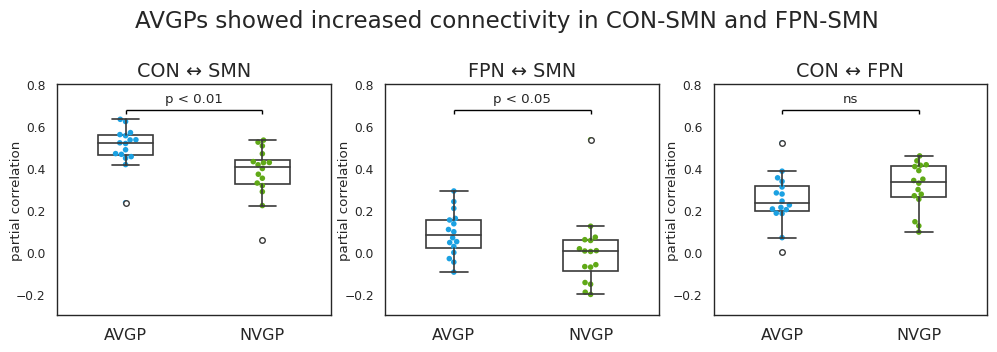

In [35]:

palette = sns.color_palette(['#1BA1E2', '#60A917'], 2)

def plot_connectivity_dist(data, src, dst, ttest_alternative='greater', plot_kde=True, box_ax=None):

    avgp = data.sel(subject=[s for s in data['subject'].values if s.startswith('AVGP')])
    nvgp = data.sel(subject=[s for s in data['subject'].values if s.startswith('NVGP')])

    avgp_conn = avgp['connectivity'].sel(
        network_src=src,
        network_dst=dst)
    nvgp_conn = nvgp['connectivity'].sel(
        network_src=src,
        network_dst=dst)

    ttest_results = report_ttest(src, dst, alternative=ttest_alternative)
    p_value = ttest_results['p-val'].values[0]
    significance_note = 'ns'
    if p_value <= 0.001:
        significance_note = 'p < 0.001'
    elif p_value <= 0.01:
        significance_note = 'p < 0.01'
    elif p_value <= 0.05:
        significance_note = 'p < 0.05'

    src = shorten_network_name(src)
    dst = shorten_network_name(dst)
    
    conn_name = f'{src}-{dst}'

    plot_data = pd.concat([
        pd.DataFrame(avgp_conn.values, columns=[conn_name]).assign(group='AVGP'),
        pd.DataFrame(nvgp_conn.values, columns=[conn_name]).assign(group='NVGP')
    ]).reset_index(drop=True)


    if plot_kde:
        fig, (kde_ax, box_ax) = plt.subplots(1, 2, figsize=(10, 3))

        sns.kdeplot(data=plot_data, x=conn_name, hue='group', cut=0, ax=kde_ax)


    sns.swarmplot(data=plot_data, x='group', y=conn_name, hue='group',
                  alpha=1,
                  legend=False,
                  size=4, palette=palette, ax=box_ax)

    sns.boxplot(data=plot_data, x='group', y=conn_name, #hue='group',
                flierprops={'marker': 'o', 'markerfacecolor': 'white', 'markersize': 4},
                width=0.4,
                boxprops={'facecolor': 'None'},
                capwidths=0.2,
                saturation=1,
                zorder=10,
                palette=palette, ax=box_ax)

    box_ax.set_ylim(-.3, .8)
    box_ax.hlines(.68, 0, 1, color='black', linestyle='-', linewidth=1)
    box_ax.vlines((0,1), .68, .66, color='black', linestyle='-', linewidth=1)
    box_ax.annotate(significance_note, xy=(.5, .73), ha='center', va='center', fontsize='medium')

    box_ax.set_xlabel(None)
    box_ax.set_ylabel('partial correlation', labelpad=-5)
    box_ax.set_xticklabels(box_ax.get_xticklabels(), fontsize='large')
    box_ax.set_title(f'{src} \N{left right arrow} {dst}', fontsize='x-large')


fig, axes = plt.subplots(1, 3, figsize=(12, 3), sharey=False)

plot_connectivity_dist(data, 'cingulo-opercular', 'sensorimotor', plot_kde=False, box_ax=axes[0])
plot_connectivity_dist(data, 'fronto-parietal', 'sensorimotor', plot_kde=False, box_ax=axes[1])
plot_connectivity_dist(data, 'cingulo-opercular', 'fronto-parietal', plot_kde=False, box_ax=axes[2])

plt.suptitle(f'AVGPs showed increased connectivity in CON-SMN and FPN-SMN',
             y=1.13, fontsize='xx-large', fontweight='normal')

plt.savefig(f'outputs/figures/group_comparisons_ttest.png', dpi=300, bbox_inches='tight')